In [2]:
from IPython import get_ipython

 # Fitting $R_t$ From COVID-19 Infection Data

 This notebook was originally based off the `Realtime R0.ipynb` calculation, but intended to produce a Bayesian posterior over the values of $R_t$ *and* $\sigma$ given the data instead of only fitting $R_t$ using a max-likelihood estimate for $\sigma$.  It has now diverged significantly; the underlying model is fairly similar to `Realtime Rt mcmc.ipynb`, but our data handling differs in that we do not attempt to account for delays between infection, onset of symptoms, and confirmation.  Instead, we are estimating $R_t$ *of confirmation* (roughly, the delay time from infection to confirmation is one to two weeks---so our estimate will lag the infection $R_t$ by a week or two).

 We use Stan to sample over the AR(1) prior for $R_t$ (increments are independent Gaussian variables) and also $\sigma$, the s.d. of the increment distribution.

 The [Stan](http://mc-stan.org) model we use for the sampling can be found in the `R0.stan` file in the current directory.

 Note that our Python environment is captured in `environment.yml`; issuing
 ```zsh
 conda env create -f environment.yml
 ```
 should duplicate it on your system.  You can then activate it via
 ```zsh
 conda activate covid-19
 ```

In [3]:
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

In [4]:
import arviz as az
import datetime
import matplotlib.dates as md
import os
import os.path
import pandas as pd
import pystan
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
sns.set_context('notebook')
sns.set_palette('colorblind')

In [5]:
def write_to_file(obj, name, ext):
    filename = 'data/' + name + '.' + ext
    try:
        obj.to_excel(filename)
    except:
        print("no folder, creating...")
        # import the os module
        import os

        # detect the current working directory
        path = os.getcwd()
        dirpath = path + "/data"
        print ("Path to created folder is %s" % dirpath)
        os.mkdir(dirpath)
        states.to_excel(filename)

 Download the dataset from https://covidtracking.com

In [6]:
url='https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive', 'negative'],
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()
states['total'] = states['positive'] + states['negative']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
states = states.reset_index()

In [8]:
# fix cumulative negatives in cases

# write pre to file for debug
#write_to_file(states, 'stan_debug_pre', 'xlsx')

def adjust_negatives(states):

    p = states.shift(-1)
    states.loc[(states.state == p.state) & (states.positive > p.positive), 'positive'] = p.positive
    
    p = states.shift(-1)
    if (((states.state == p.state) & (states.positive > p.positive)).any()):
        states = adjust_negatives(states)
        return states
    else:
        return states

states = adjust_negatives(states)
states.positive = states.positive[states.positive.notnull()].apply(lambda x: int(x))

# write post to file for debug
#write_to_file(states, 'stan_debug_post', 'xlsx')

states = states.set_index(['state', 'date'])
states = states.sort_index()

 Compile the Stan model that simultaneously fits for $R_t$ and $\sigma$.  Our model differs from that in http://rt.live in several respects.  Trivially, we choose different priors on $\sigma$ (the scatter from one day to the next in the imposed prior on $R_t$), the first day's infection count, and $R_1$.

 We differ from the default implementation at http://rt.live more significantly in that we use the last day's *expected* number of counts to predict the current day's expected numbers via $R_t$:
 $$
 \Lambda_{i+1} = \Lambda_i \exp\left( \frac{R_{i+1} - 1}{\tau} \right);
 $$
 we use a Poisson measurement model, where
 $$
 k_{i+1} \sim \mathrm{Poisson}\left( \Lambda_{i+1} \right);
 $$
 we have tried Binomial measurement models (see `Stan R0-Binomial.ipynb`) and also negative binomial (over-dispersed Poisson), but neither seems to work very well.  The Binomial model suffers because the total numbers of tests are not well curated; also, theoretically, Binomial would only be appropriate if the number of tests on a given day were fixed in advance, which is not very representative of how the testing is done.  Negative binomial is [sometimes used](https://mrc-ide.github.io/covid19estimates/#/) to inflate the uncertainty from a Poisson measurement model; but here, since the $R_t$ timeseries *can* fit any data to arbitrary accuracy, there is no "traction" on $\phi$ (the over-dispersion parameter), and the data prefer pure Poisson models.  We could *impose* a $\phi$ (i.e. over-disperse the Poisson by hand), but I am currently not sure which $\phi$ it would be appropirate to choose.

 http://rt.live instead uses the last day's *observed* counts to predict the current day's expected counts:
 $$
 \Lambda_{i+1} = k_i \exp\left( \frac{R_{i+1}-1}{\tau} \right);
 $$
 they also use a Poisson measurement model:
 $$
 k_{i+1} \sim \mathrm{Poisson}\left( \Lambda_{i+1} \right)
 $$
 The http://rt.live model is odd, in that the *observed* counts are not necessarily the thing that grows exponentially in the SIR model---the observed counts have Poisson sampling noise in them, while the thing that grows exponentially is the *true* number of infected in the population.  The effect of using $k_i$ instead of $\Lambda_i$ is a reduction in the uncertainty on $R_t$, since $k_i$ is conditioned on, and therefore fixed, while $\Lambda_i$ carries some uncertainty.

 One final complication is that we marginalize over the serial number, using a log-normal distribution that matches to a measured mean and s.d.

In [9]:
model = pystan.StanModel(file='R0.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1007735bdb01a235a07b644db6a71242 NOW.


 We marginalize over the serial time, based on the mean and standard deviation reported at https://epiforecasts.io/covid/ (which, in turn, come from [Nishiura, Linton, & Akhmetzhanov (2020)](https://doi.org/10.1101/2020.02.03.20019497)).

In [10]:
serial_mean = 4.7
serial_std = 2.9

 Smoothing has been a constant issue; there are weird day-by-day trends in the data.  For example, here is the time-series of log-odds for NY:

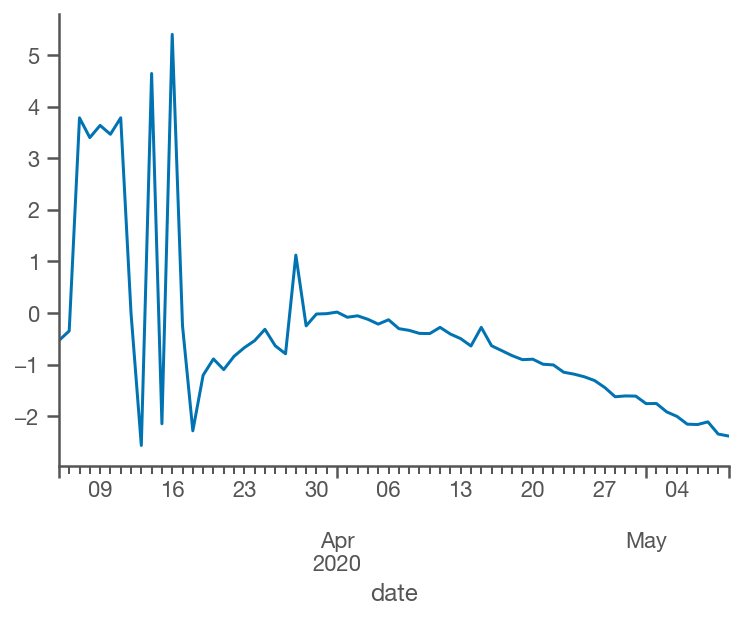

In [11]:
ny = states.loc['NY']

out = (np.log(ny['positive'].diff().dropna() + 1) - np.log(ny['total'].diff().dropna() - ny['positive'].diff().dropna() + 1)).plot()

 There is some total junk (low numbers!) in the early data, followed by a pretty reasonable rising and then falling trend (yeah!).  But even in the later data, there are some individual day outliers.  In any case, the the distribution of time between infection to symptoms to confirmation via test is quite broad (at least a week or two, with s.d. maybe one week) that it seems reasonable to smooth the time-series some.  In the past I had used an exponential filter, but that does not provide very much smoothing of the high-frequency components unless the timescale is very long; a Gaussian filter is much smoother.  Convolving in the time-domain with a Gaussian
 $$
 g(\tau) = \exp\left[ -\frac{\tau^2}{2 \sigma^2} \right]
 $$
 is equivalent to multiplication in the frequency domain by
 $$
 \tilde{g}(f) \propto \exp\left[ -\frac{f^2}{2 \kappa^2} \right],
 $$
 with width
 $$
 \kappa = \frac{1}{2\pi \sigma}.
 $$
 If we want to suppress fluctuations on longer than 7-day timescales by a factor of 10 (this may be too much smoothing, but let's go with it for now), then we want to choose
 $$
 \frac{\left( 1 / 7 \, \mathrm{d} \right)^2}{2 \kappa^2} = \log 10,
 $$
 or
 $$
 \sigma \simeq 2.4 \, \mathrm{d}.
 $$

 Lately http://rt.live has been using a method for projecting cases back to time of onset that effectively filters on a ~7 day timescale; a discussion, including my rationale for not using that method, can be found [here](https://github.com/k-sys/covid-19/issues/43).  Note that smoothing an exponential timeseries with another exponential *does not change the series timeconstant*, so we might think (hope?) that we are still estimating the local $R_t$ in this manner.

 Note that the Gaussian filter is *acausal*; the comment [here](https://github.com/k-sys/covid-19/issues/30), argues for using a causal filter to preserve the "accumulative" property of Bayseian inference.  However, note that our prior on $R_t$ is *already* acausal because we fit $\sigma$ from the full data set.

In [12]:
smooth_std = 2.4

 Our model is that $\log R_t$ random-walks with some scale $\sigma$.  Totally off the top of my head, I would not expect $R_t$ to change by a factor larger than, say, $\sqrt{2}$ in one week (so $\log \sigma$ increments by $\log \sqrt{2}$).  Since in a random walk variances add, and $\sigma$ is the scale of the walk step *per day*, we have
 $$
 7 \times \sigma^2 \lesssim \left(\log \sqrt{2}\right)^2
 $$
 or
 $$
 \sigma \lesssim \frac{\log \sqrt{2}}{\sqrt{7}} \simeq 0.13
 $$

 We choose a prior for $\sigma$ that is
 $$
 \sigma \sim N\left( 0, 0.05 \right),
 $$
 so that this "extreme" value of $\sigma$ lies a bit outside 2-$\sigma$.

In [13]:
sigma_scale = 0.05

 ## One State By Hand

 Here we do my home state (NY) by hand, just to show aspects of the data processing, fitting, and plotting; stay tuned for the bulk run.  Note that we cut out samples from a time before the state has tested (cumulatively) 1000 people, since these are the "junk" above.

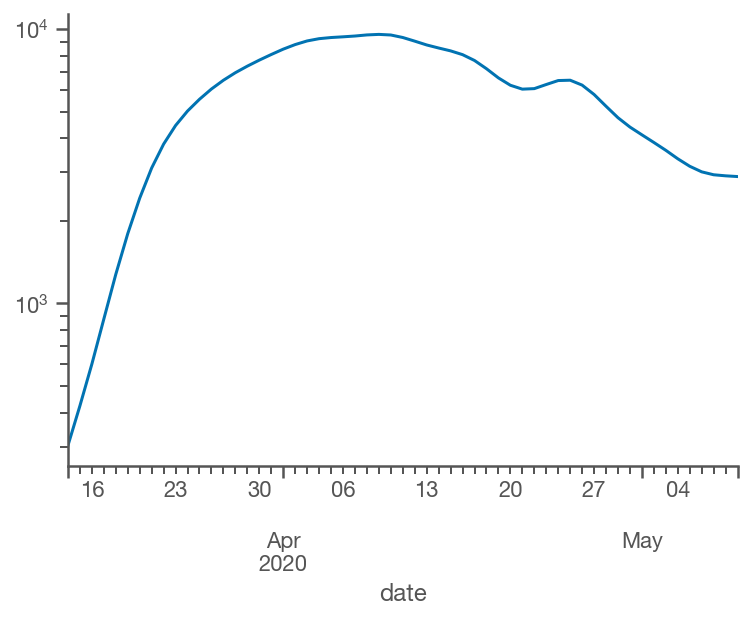

In [14]:
this_state = 'NY'
ny = states.loc[this_state]
istart = np.where(ny['total'] > 1000)[0][0]
ny = ny.iloc[istart:]
pos = ny['positive'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)

pos.plot()

data = {
    'ndays': len(pos),
    'k': pos.round().astype(np.int),
    
    'tau_mean': serial_mean,
    'tau_std': serial_std,
    
    'sigma_scale': sigma_scale
}

plt.yscale('log')

 Run the fits, hinting to `arviz` that it should use the appropriate date-time coordinates for the expected number of counts and $R_t$.

In [15]:
fit_stan = model.sampling(data=data)
fit = az.from_pystan(fit_stan, 
                     coords={'dates': data['k'].index,
                             'Rt_dates': data['k'].index[1:]},
                     dims={'Rt': ['Rt_dates'],
                           'log_odds': ['dates']})

In [16]:
# temporarily suppress UserWarning
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

 A quick traceplot, just because it looks pretty:

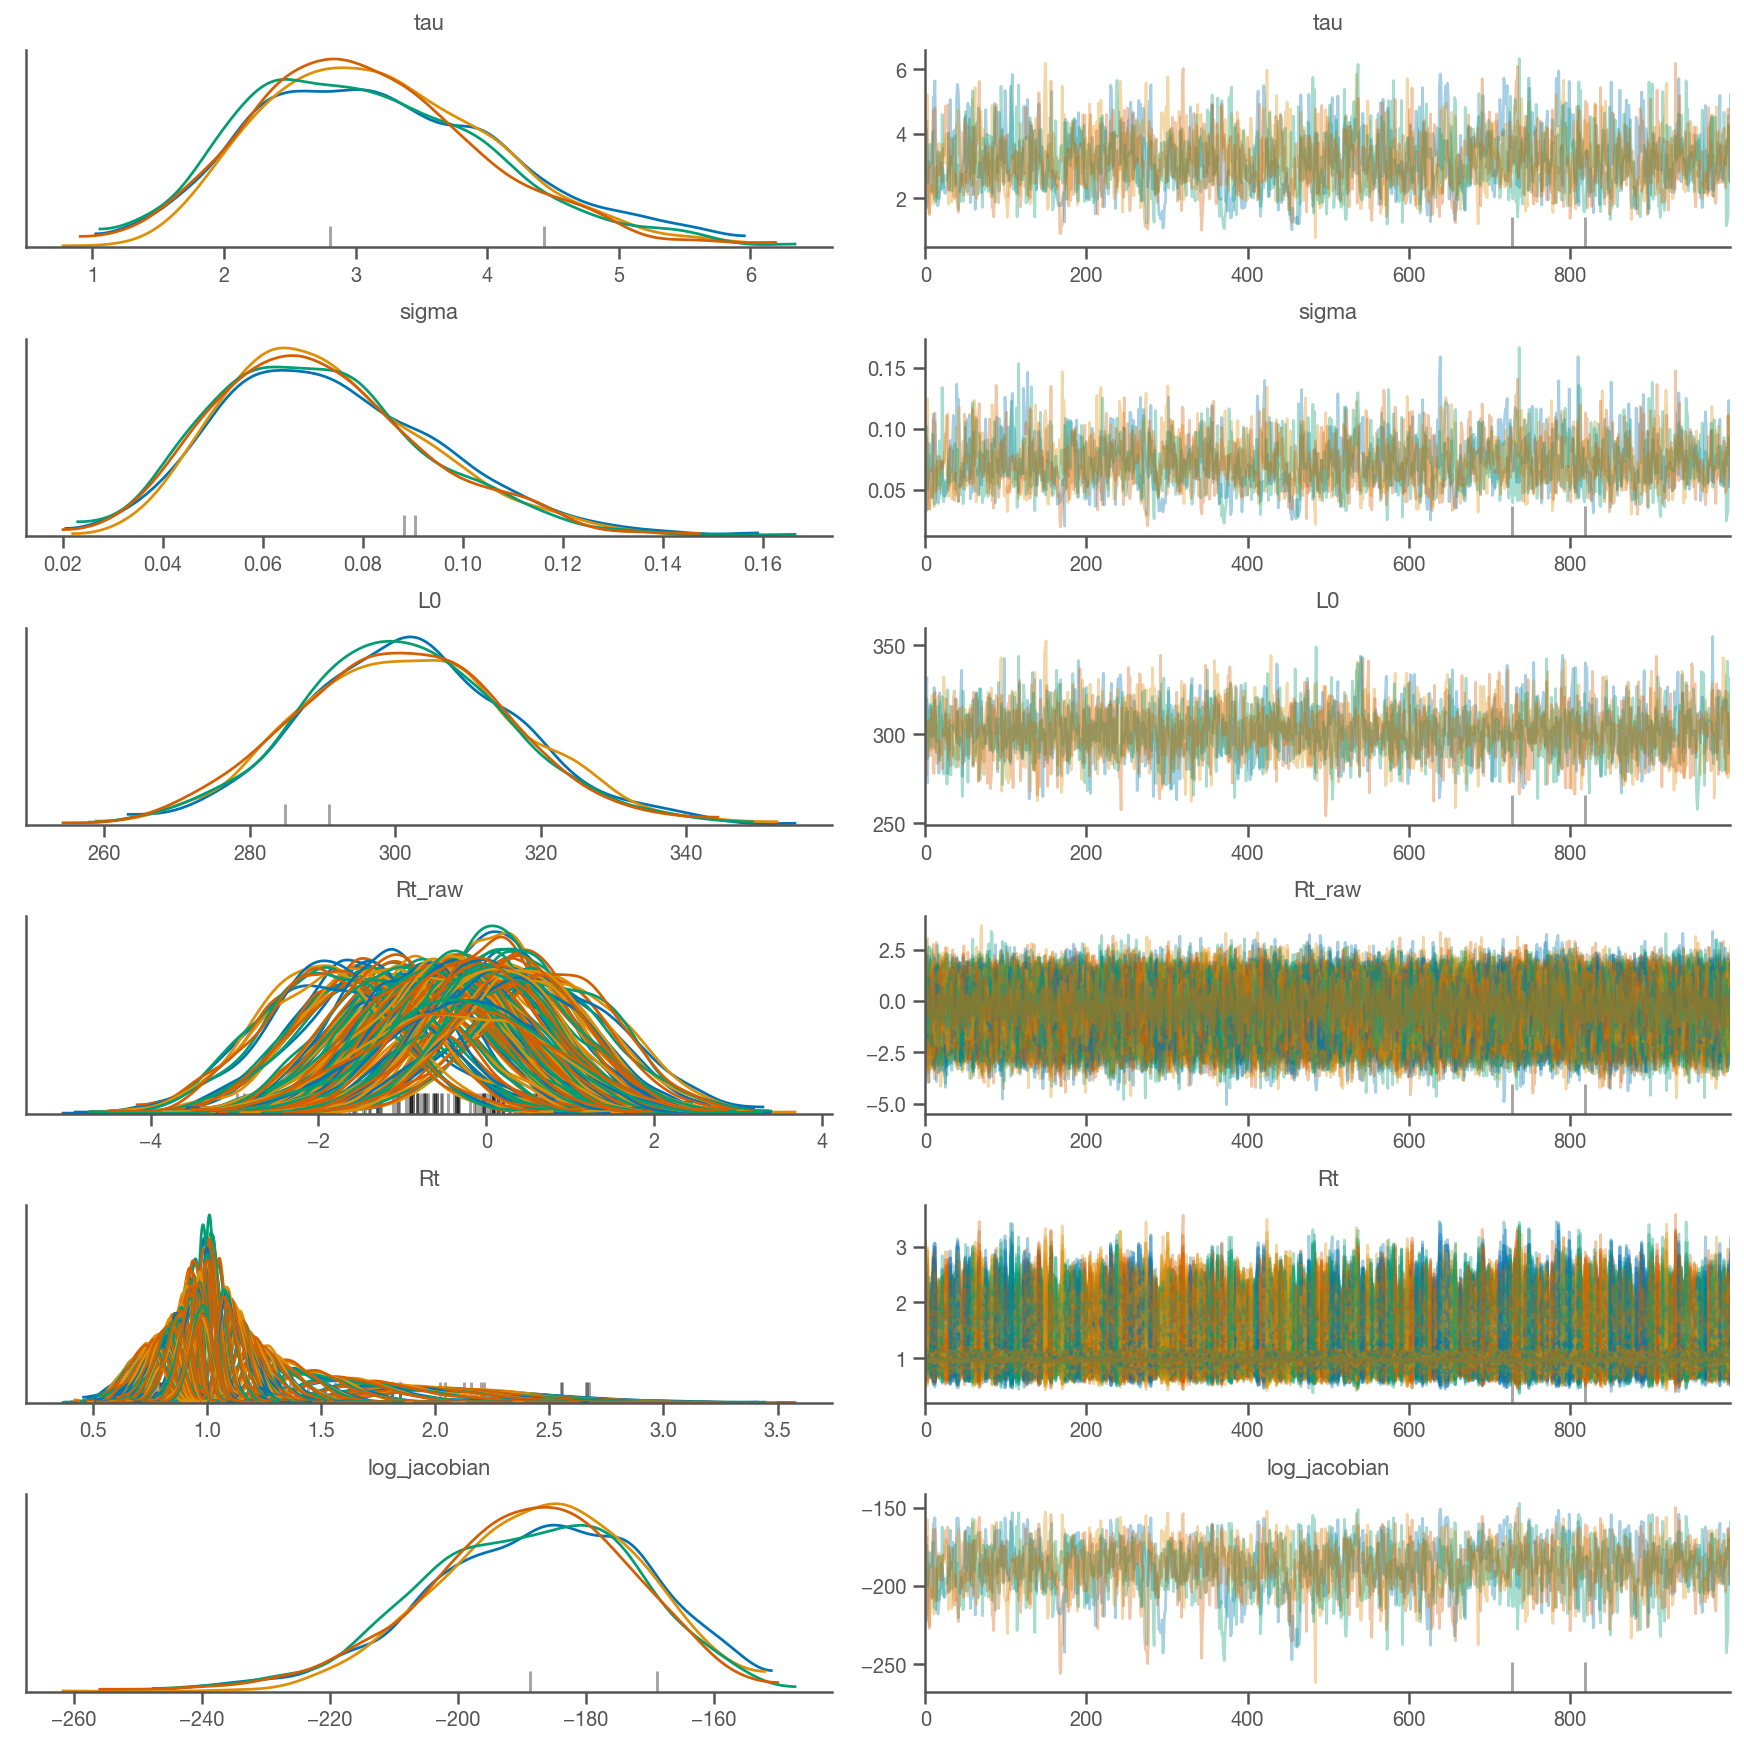

In [17]:
out = az.plot_trace(fit, compact=True)

In [18]:
# reactivate UserWarnings
warnings.filterwarnings("default", category=UserWarning)

In [19]:
# customized layout

from datetime import datetime as dtime
from datetime import timedelta

date_now = dtime.now()
date_then = dtime.now() - timedelta(days=48)

rtlive = ["#5db044", "#da5d5d", "#95a5a6", "#e74c3c", "#34495e"]
sns.set_palette(rtlive)

In [20]:
def plot_graph(fit, ax, state, single=False):

    m = np.median(fit.posterior.Rt, axis=(0,1))
    hh = np.percentile(fit.posterior.Rt, 97.5, axis=(0,1))
    h = np.percentile(fit.posterior.Rt, 84, axis=(0,1))
    l = np.percentile(fit.posterior.Rt, 16, axis=(0,1))
    ll = np.percentile(fit.posterior.Rt, 2.5, axis=(0,1))

    x = fit.posterior.Rt_dates.values
    line_1 = np.ones(len(x))

    # NOTE: try this approach instead (filling with NaN):
    m_good = m.copy()
    m_bad = m.copy()
    m_good[m_good > 1.30] = np.nan
    m_bad[m_bad <= 0.98] = np.nan

    ax.plot(x, m_good, ls='-', marker='', lw=1.5, color=sns.color_palette()[0])
    ax.plot(x, m_bad, ls='-', marker='', lw=1.5, color=sns.color_palette()[1])
    
    ax.fill_between(x, np.where(hh<1, hh, 1) , np.where(ll<1, ll, 1), alpha=0.10, color=sns.color_palette()[0])
    ax.fill_between(x, np.where(hh>1, hh, 1) , np.where(ll>1, ll, 1), alpha=0.10, color=sns.color_palette()[1])
    
    ax.plot(x, line_1, ls='dotted', color = sns.xkcd_rgb["light grey"], lw=3)

    if single:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    else:
        date_fmt = md.DateFormatter('%m-%d')
        ax.xaxis.set_major_formatter(date_fmt)
    
    ax.set_title(state, fontsize=16, color='xkcd:dark grey')
    ax.set_ylabel(r'$R_t$')

    ax.set_xlim([date_then, date_now])

    ax.set_ylim(bottom = 0,
                top = 3,
                auto = False)
    sns.despine()

    return True

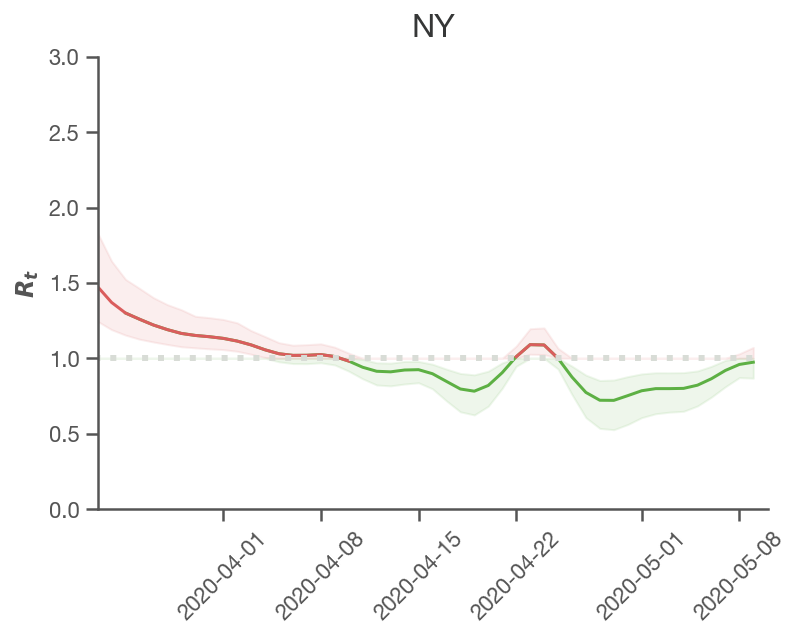

In [21]:
fig, ax = plt.subplots()
out = plot_graph(fit, ax, this_state, single=True)

 Something interesting is happening here: we seem to be getting better inferences for $\tau$ (the serial time) than the prior.  This is, in principle, possible---for example, we should get very good inferences on $\tau$ if the positive rate declines significantly, since $R_t \geq 0$ implies that the most extreme decay is $\Lambda(t) \sim \exp\left( -t / \tau \right)$.  Posterior in blue, prior in black (recall that the prior is chosen so that it has the same mean and s.d. as the quoted interval for $\tau$ from previous research).

 Before we make too much of this, we should probably check the effect of our smoothing, which suppresses changes on short timescales (we chose the smoothing time so that Fourier modes with frequencies larger than $1/\left( 7 \, \mathrm{d} \right)$ will be suppressed by an order of magnitude or more); this could be leading to the larger inference for $\tau$.

 Worth following up on later.

In [22]:
# reset to orig palette
sns.set_palette('colorblind')

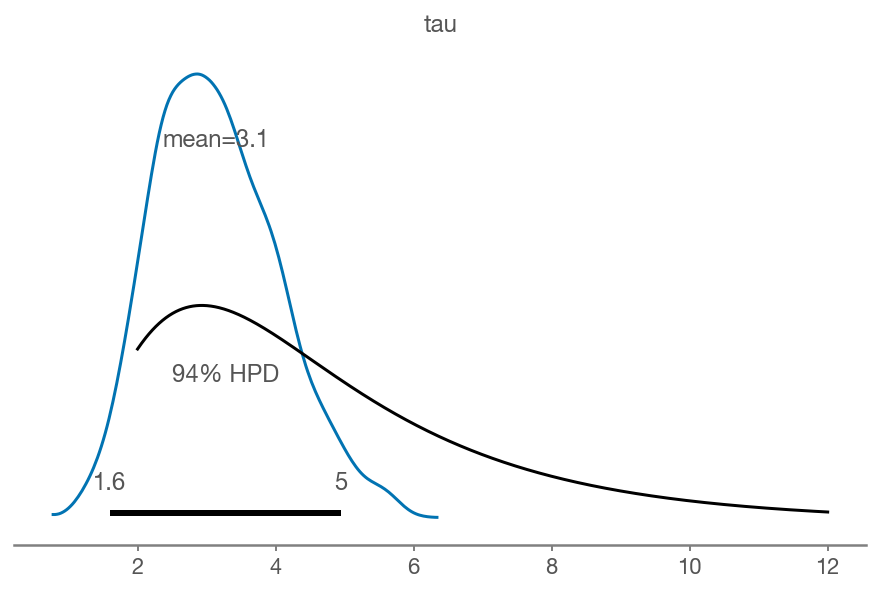

In [23]:
az.plot_posterior(fit, var_names='tau', )
xs = np.linspace(2, 12, 1024)
out = plt.plot(xs, ss.lognorm(0.57, scale=np.exp(1.4)).pdf(xs), '-k')

 ## All States

In [24]:
def fit_state(states, state_key):
    st = states.loc[state_key]
    
    istart = np.where(st['total'] > 1000)[0][0]
    st = st.iloc[istart:]

    pos = st['positive'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)
    # tot = st['total'].diff().dropna().rolling(int(round(5*smooth_std)), min_periods=1, center=True, win_type='gaussian').mean(std=smooth_std)
    
    data = {
        'ndays': len(pos),
        'k': pos.round().astype(np.int),
        # 'n': tot.round().astype(np.int),
        
        'tau_mean': serial_mean,
        'tau_std': serial_std,
        'sigma_scale': sigma_scale
    }
    
    if len(pos) == 0:
        raise RuntimeError("can't fit an empty data set")
    
    tries = 0
    iter = 2000
    thin = 1
    while tries < 3:
        fit = az.from_pystan(model.sampling(data=data, iter=iter, thin=thin), 
                             coords={'dates': pos.index,
                                     'Rt_dates': pos.index[1:]},
                             dims={'Rt': ['Rt_dates'],
                                   'log_odds': ['dates']})
        ess = az.ess(fit, var_names=['tau', 'sigma', 'L0', 'Rt']).min()
        if ess.tau > 1e2 and ess.sigma > 1e2 and ess.L0 > 1e2 and ess.Rt > 1e2 and np.all(az.bfmi(fit) > 0.2):
            break
        else:
            tries += 1
            iter *= 2
            thin *= 2
    
    return fit



 We run the fit on each state (takes ten-twenty minutes on my MacBook); some states have no data, so we skip those.

In [25]:
state_fits = {}
with tqdm(states.groupby(level=0)) as bar:
    for st, _ in bar.iterable:
        try:
            if np.all(np.isnan(states.loc[st]) | (states.loc[st] == 0)):
                bar.write('Skipping state: {:s}'.format(st))
                bar.update(1)
                continue
            state_fits[st] = fit_state(states, st)
            bar.update(1)
        except (RuntimeError, IndexError):
            bar.write('State {:s} failed with RuntimeError; skipping'.format(st))
            bar.update(1)
            continue

  5%|▌         | 3/56 [04:18<1:49:20, 123.78s/it]

State AS failed with RuntimeError; skipping


 23%|██▎       | 13/56 [05:22<06:49,  9.53s/it]

State GU failed with RuntimeError; skipping


 50%|█████     | 28/56 [12:19<11:33, 24.77s/it]

State MP failed with RuntimeError; skipping


 54%|█████▎    | 30/56 [12:47<07:49, 18.04s/it]

State MT failed with RuntimeError; skipping


 91%|█████████ | 51/56 [28:33<00:58, 11.69s/it]

State VI failed with RuntimeError; skipping


100%|██████████| 56/56 [30:17<00:00, 32.46s/it]


 Save all the fits; use `load_state_fits` (untested) to load them back in.

In [26]:
import glob

In [27]:
def save_state_fits(fits, directory):
    try:
        os.makedirs(directory)
    except OSError:
        pass

    # clean out old files
    files = glob.glob(directory + '/*')
    for f in files:
        os.remove(f)

    for k, f in fits.items():
        fname = os.path.join(directory, k + '.nc')
        fname_tmp = fname + '.temp'
        az.to_netcdf(f, fname_tmp)
        os.rename(fname_tmp, fname)

def load_state_fits(directory):
    fits = {}
    for f in glob.glob(os.path.join(directory, '*.nc')):
        k = os.path.splitext(os.path.split(f)[1])[0]
        fits[k] = az.from_netcdf(f)
    return fits

In [28]:
save_state_fits(state_fits, 'state_fits_US')

In [29]:
#from collections import OrderedDict 

#state_fits = load_state_fits('state_fits_US')
#state_fits = OrderedDict(sorted(state_fits.items()))

In [30]:
# set customized palette
sns.set_palette(rtlive)

 And make a plot that is similar to the one at http://rt.live

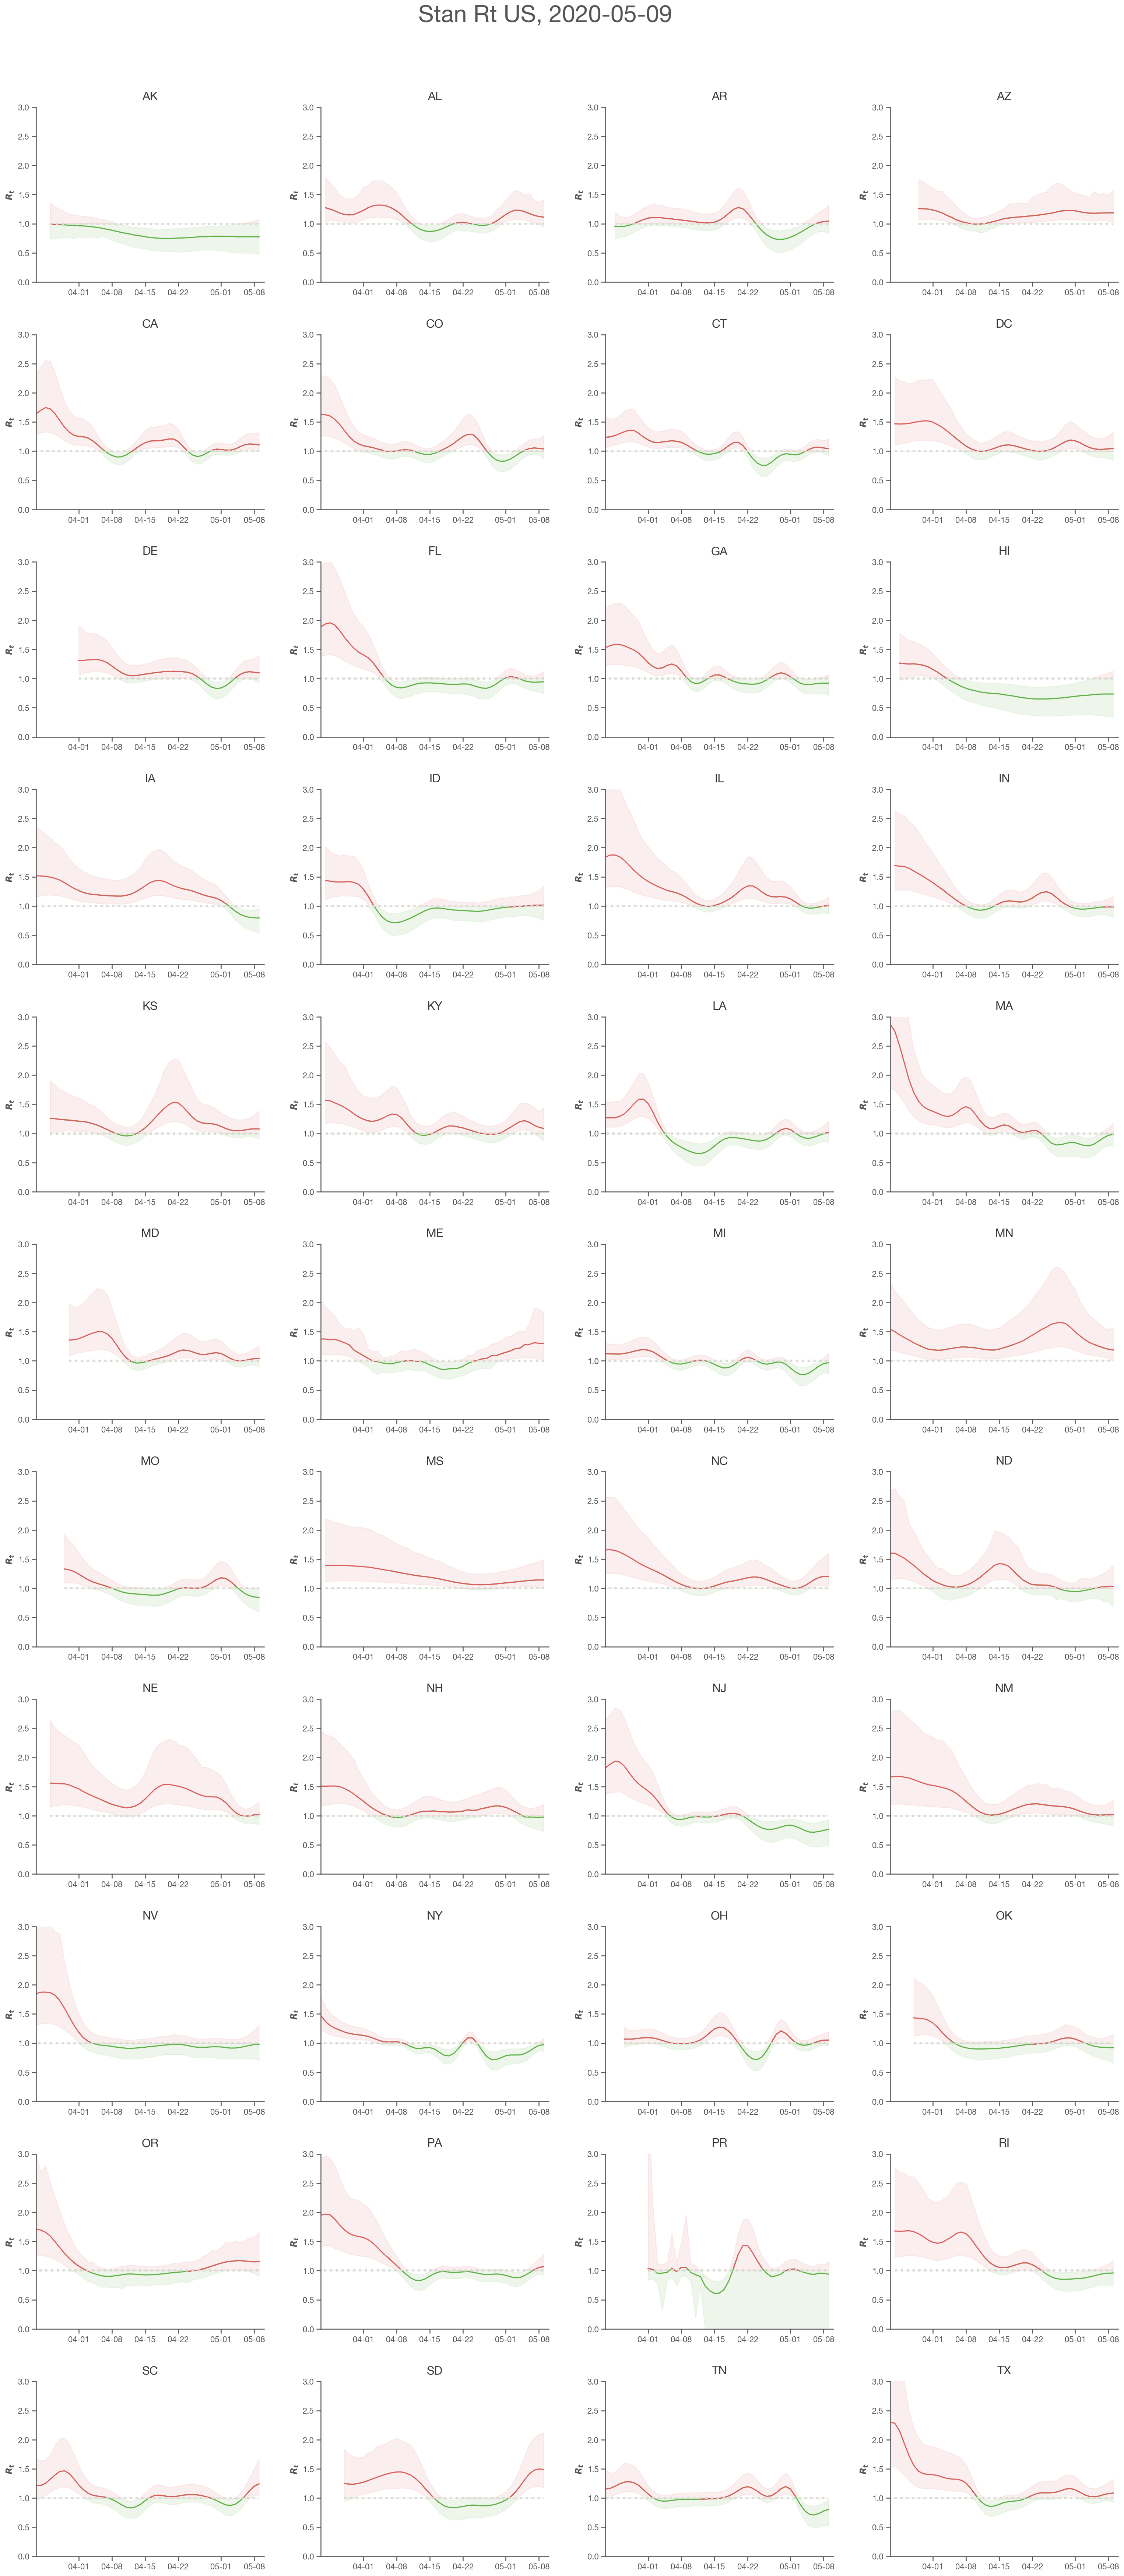

In [31]:
nc = 4
nr = 11
excluded = []
out = [state_fits.pop(x, None) for x in excluded]

# temporarily limit states for testing purposes, set to 0 for unlimited
state_count = 0

fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(24, 5*nr))

count = 0;
for idx, ((k,fit), ax) in enumerate(zip(state_fits.items(), axes.flatten())):
    
    if ((state_count != 0) & (count >= state_count)):
        [ax.set_visible(False) for ax in axes.flatten()[idx:]]
        break

    out = plot_graph(fit, ax, k)

    count +=1

else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

this_date = dtime(2020, 5, 9).strftime('%Y-%m-%d')
#this_date = dtime.today().strftime('%Y-%m-%d')
fig_title = "Stan Rt US, " + this_date
fig.suptitle(fig_title, y=0.955, fontsize=32)
fig.set_facecolor('w')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.30, wspace=0.25)

In [32]:
# reset to orig palette
sns.set_palette('colorblind')

Here is a nice plot that shows the distribution of $R_t$ at the latest day of sampling, ordered by its median value:

In [33]:
nc = 4
nd = 1000

d = {'state': [], 'Rt': []}
for k, f in state_fits.items():
    d = {'state': np.concatenate((d['state'], (k,)*(nc*nd))), 
         'Rt': np.concatenate((d['Rt'], f.posterior.Rt[:,:,-1].values.flatten()))}
df = pd.DataFrame(d)

sort_Rts = [np.median(fit.posterior.Rt[:,:,-1]) for fit in state_fits.values()]
state_order = np.array(list(state_fits.keys()))[np.argsort(sort_Rts)]

Compare to http://rt.live:

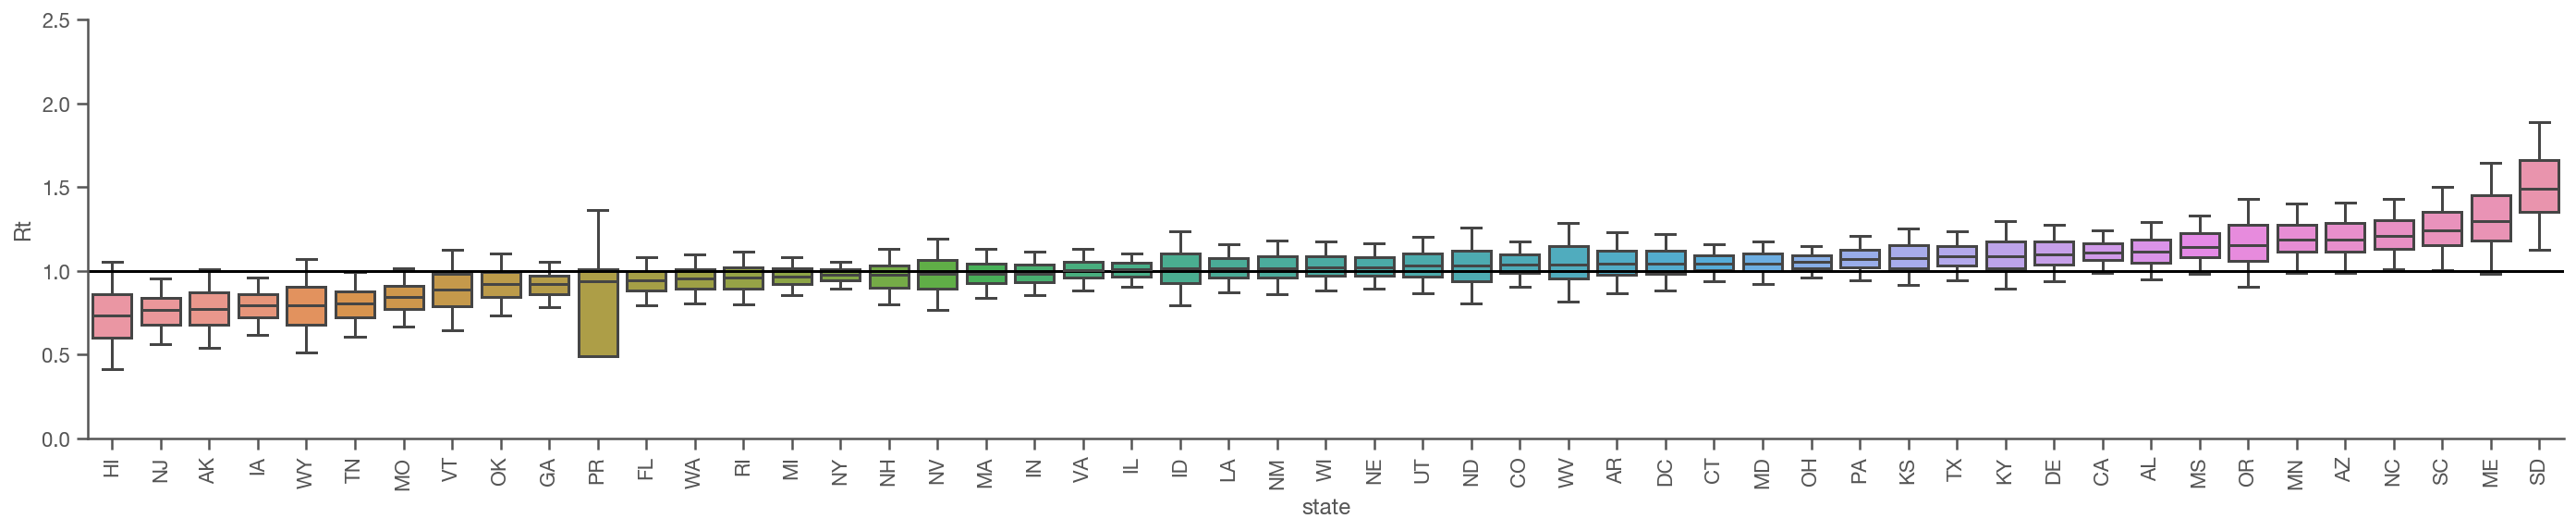

In [34]:
plt.figure(figsize=(24,4))
sns.boxplot(x='state', y='Rt', data=df, order=state_order, fliersize=0, whis=1.0/1.35, )
plt.axhline(1, color='k')
plt.xticks(rotation=90)
out = plt.axis(ymin=0, ymax=2.5)

Should check in on this model for $\tau$---in the states where it is well-measured, we favor a slightly smaller $\tau$ than the default prior.  Might be worth building a hierarchical model to re-infer $\tau$ from the national data....  Black line is the prior.

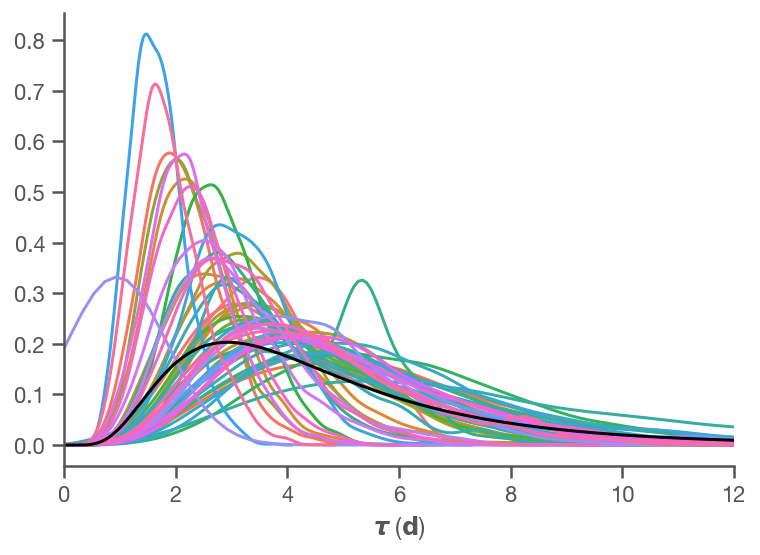

In [35]:
with sns.color_palette('husl', n_colors=len(state_fits)):
    for f in state_fits.values():
        sns.kdeplot(f.posterior.tau.values.flatten())
xs = np.linspace(0, 20, 1024)
plt.plot(xs, ss.lognorm(0.57, scale=np.exp(1.4)).pdf(xs), color='k')
plt.axis(xmin=0,xmax=12)

out = plt.xlabel(r'$\tau$ ($\mathrm{d}$)')